Make sure to install LASIO package to read LAS files.

#### pip install lasio

Also make sure you have sklearn package installed as we will be using that module exclusively for this tutorial.



## Predicting Logs using Machine Learning
### Sundeep Sharma, Devon Energy, email: sharmasundeep89@gmail.com

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0,'F:/python_libraries/lasio-master/')
import lasio

In [5]:
training_path='./training_logs/'
blind_path='./blind_logs/'

Every geoscientist in the oil and gas industry is familiar with the importance of compressional sonic logs (commonly used mnemonic, DT).  DT logs are incredibly important for day-to-day geophysical workflows. DT logs are key for seismic-to-well tie as well as their reciprocal, compressional velocity (Vp), is key for background model building in seismic inversions. Unfortunately, some basins we work in have a scant distribution of DT logs that can hinder confident interpretation in areas with lacking sonic data. Just a few months back I ran into such a problem while working in an onshore basin. While having a casual conversation with my colleague, we contemplated on the idea of DT prediction using triple combo logs (density, porosity, resistivity and gamma). One common way of converting from density logs to DT is the inverse gardner relationship (Gardner et al.,1974). However, as we will see later in this tutorial, its empirical nature fails to properly calculate a true Vp or DT response from density. Interestingly, at the time of the conversation, I was enrolled in a Machine Learning course on Coursera, taught by Andew Ng, and was immediately drawn towards testing out my newly acquired machine learning skills to tackle this problem. So in this tutorial, I will share with you my workflow for DT prediction using triple combo logs.  We will be using the freely available Teapot Dome 3D dataset and utilize Python's $\textit{scikit-learn}$ library. So without any further ado, let’s dive right into it.

In [6]:
df_combined=pd.DataFrame()
for (dirname,dirs,files) in os.walk(training_path):
    for fl in files:
        if fl.endswith('.LAS'):
            log=lasio.read(os.path.join(training_path,fl))
            log.curves['DEPT'].mnemonic='DEPTH'
            uwi=log.well.API.value
            name=log.well.WELL.value
            df_core=log.df()
            df_core['UWI']=uwi
            df_combined=pd.concat([df_combined, df_core])

            
training=df_combined[['DEPTH','DT','GRR','NPHI','ILD','RHOB','UWI']]

training=training.dropna(how='any')
training=training.reset_index(drop=True)


The first step is to get a training dataset. I have combined two las file into one dataframe as the training data. Both the logs contained DT, GR, NPHI, ILD and RHOB. You can use more logs for training, I have just kept it simple by using two. Below is a table that shows the first five rows of the dataset. 

In [7]:
training.head()

,DEPTH,DT,GRR,NPHI,ILD,RHOB,UWI
0,2088.0,91.578,94.849,0.233,6.296,2.472,49025109650000
1,2088.5,91.578,91.132,0.233,6.244,2.473,49025109650000
2,2089.0,91.578,87.114,0.238,6.165,2.484,49025109650000
3,2089.5,91.578,85.320,0.237,6.086,2.493,49025109650000
4,2090.0,91.578,84.879,0.235,6.007,2.493,49025109650000


## Training/Test Phase

Now that we have the training dataset, we will go through the training/test phase. Firstly, we will shuffle the data to ensure we get rid of any bias/patterns within the dataset before we split the data into training and validation sets. Scikit-learn has an inbuilt "shuffle" funcion that we will use to shuffle the dataset. We will then drop the Depth, DT and UWI columns to create our feature vectors. The DT column is our observed data.

In [8]:
from sklearn.utils import shuffle
training=shuffle(training,random_state=20)
drop_curves=['DEPTH','DT','UWI']
feature_vectors=training.drop(drop_curves,axis=1)
y_actual=training['DT'].values

We will split the data into $20\%$ test set and $80\%$ training set. Next, we will standardize the dataset, which is a way of making the features Gaussian with zero mean and unit variance. We will use the same scalar to standardize the blind dataset that we will test on. Both, the splitting and standardizing, can be done easily with scikit-learn modules $\textit{model_selection}$ and $\textit{preprocessing}$, respectively. 

In [9]:
from sklearn import model_selection
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)


validation_size = 0.20 
seed = 42
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(scaled_features,                                                                                
                                 y_actual,                                               
                                 test_size=validation_size,                                                                                 
                                 random_state=seed)


Now that we have our normalized training and validation dataset, we will train the data using three algorithms; Linear Regression, Ridge Regression and Lasso. There are many other regressors we can use but for sake of simplicity I have chosen three very popular ones. The training and prediction is done in few very simple steps with scikit-learn. We first call the specific regressor using the $\textit{linear-model}$   module in scikit-learn and then fit the training data. Then, we can predict the output (DT in our case) on the validation/test set.  

In [50]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()
reg_lin = lin_reg.fit(X_train, Y_train).predict(X_validation)

reg = linear_model.Ridge(alpha=1,tol=0.01, solver='sag')
ridge_reg = reg.fit(X_train, Y_train).predict(X_validation)

lasso=linear_model.Lasso(alpha=0.1)
lasso_lin=lasso.fit(X_train,Y_train).predict(X_validation)

We can then check the accuracy of prediction using some metrics built in to scikit-learn. We will particularly look at $R^{2}$ and Mean Square Error (MSE) statistic.

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

# POLYNOMIAL FITTING FOR ALL THE ALGORITHMS USED #
fit_fn1 = np.poly1d(np.polyfit(Y_validation,ridge_reg, 1)) 
fit_fn2 = np.poly1d(np.polyfit(Y_validation,reg_lin, 1)) 
fit_fn3 = np.poly1d(np.polyfit(Y_validation,lasso_lin, 1)) 

# CALCULATE R2 FOR ALL THE PREDICTIONS #
lr_r2=r2_score(Y_validation,reg_lin)
ridge_r2=r2_score(Y_validation,ridge_reg)
lasso_r2=r2_score(Y_validation,lasso_lin)

print "Linear Regression: R2:",lr_r2, "| MSE:",mean_squared_error(Y_validation,reg_lin)
print "Ridge Regression: R2:",ridge_r2, "| MSE:",mean_squared_error(Y_validation,ridge_reg)
print "Lasso: R2:",lasso_r2, "| MSE:",mean_squared_error(Y_validation,lasso_lin)


Linear Regression: R2: 0.725676548108 | MSE: 16.2265967436
Ridge Regression: R2: 0.725402906806 | MSE: 16.2427829903
Lasso: R2: 0.725096088973 | MSE: 16.2609316729


As we see from the statistic above, all three methods have very similar performance. We can also plot the actual vs. predicted DT for the validation/training set for all three regressors. 

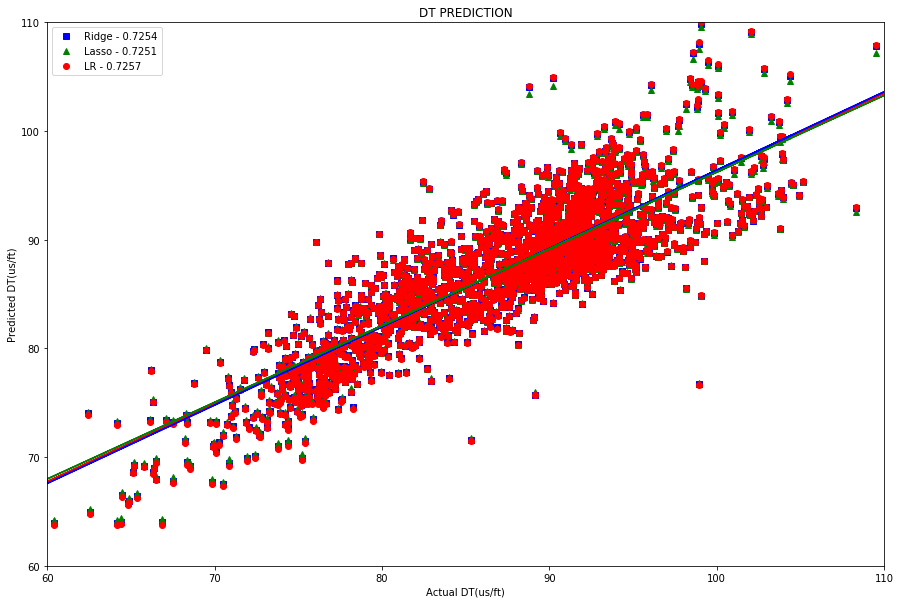

In [52]:
fig = plt.figure(figsize=(15, 10))
plt.plot(Y_validation,ridge_reg,'bs',Y_validation,lasso_lin,'g^',
         Y_validation,reg_lin,'ro',
         Y_validation,fit_fn1(Y_validation),
         'r-',Y_validation,fit_fn2(Y_validation),'b-',
         Y_validation,fit_fn3(Y_validation),'g-')
plt.xlabel('Actual DT(us/ft)')
plt.ylabel('Predicted DT(us/ft)')
plt.legend(['Ridge - '+str(round(ridge_r2,4)),'Lasso - '+str(round(lasso_r2,4)),
            'LR - '+str(round(lr_r2,4))])
plt.xlim(60,110)
plt.ylim(60,110)
plt.title('DT PREDICTION')
plt.show()

We can create a quick residul plot for one of our prediction algorithm. This is a good way to ensure that the data is randomly scattered around zero and there is no visible structure or pattern in the dataset. If there is a structure within the dataset, we need to look at the input variables and the interaction between them.  

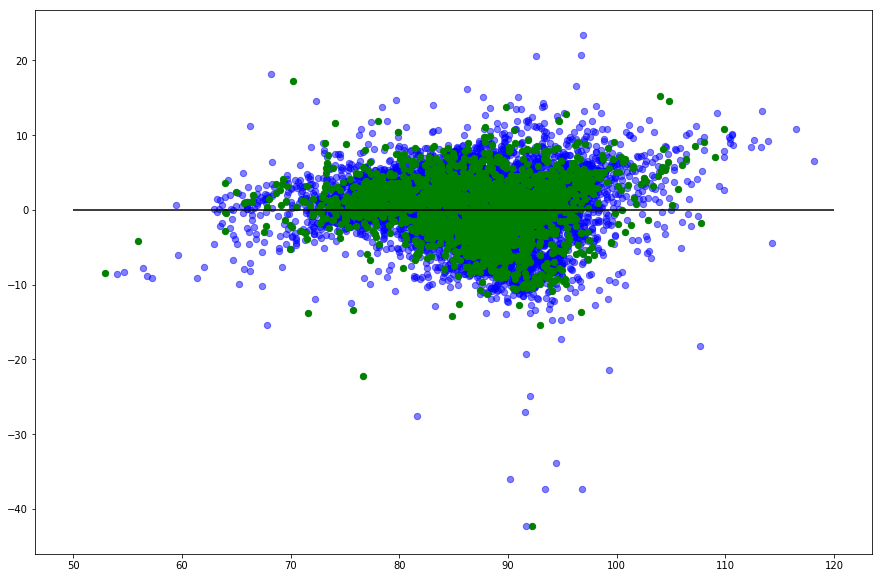

In [53]:
# Residual plot
fig = plt.figure(figsize=(15, 10))

plt.scatter(reg.predict(X_train),reg.predict(X_train)- Y_train,c='b',s=40, alpha=0.5)
plt.scatter(reg.predict(X_validation),reg.predict(X_validation)- Y_validation,c='g',s=40)
plt.hlines(y=0,xmin=50,xmax=120)
plt.show()


Now that we know all three methods give very similar result, let's take Ridge Regression and Lasso, and see what happens to our prediction as we change the $\textit{alpha}$ $(\alpha)$ parameter. $\alpha$  term is a regularization term that is used to penalize the coefficient. For Ridge Regression, the regularization is given by l2-norm and for Lasso it is given by an l1-norm. For both algorithms, larger value of $\alpha$ specific stronger regularization.

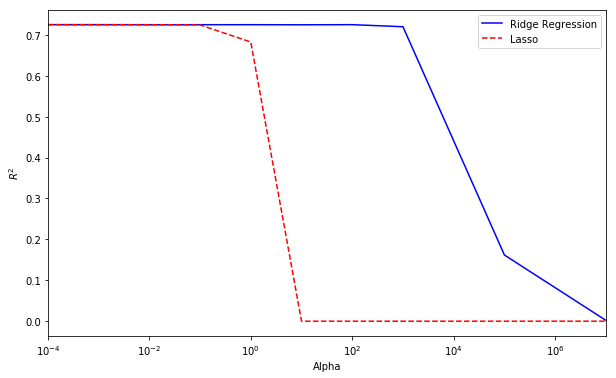

In [54]:
a = []
b= []
c= []

do_model_selection = True

if do_model_selection:
    alp=np.array([0.0001, 0.001, 0.01, 0.1, 1,10, 100, 1000, 100000,10000000])
    for outer_ind,alp in enumerate(alp):
        reg_test = linear_model.Ridge(alpha=alp,tol=0.01, solver='sag')
        reg_test.fit(X_train, Y_train)
        
        lasso_test=linear_model.Lasso(alpha=alp)
        lasso_test.fit(X_train, Y_train)
        
        r2_ridge=r2_score(Y_validation,reg_test.predict(X_validation))
        r2_lasso=r2_score(Y_validation,lasso_test.predict(X_validation))
        a.append(alp)
        b.append(r2_ridge)
        c.append(r2_lasso)
df = pd.DataFrame({'alpha': a, 'r2_ridge': b,'r2_lasso': c})
del a, b, c
    
fig, ax = plt.subplots(figsize=(10,6))
df.plot(x='alpha',y='r2_ridge',logx=True,ax=ax, style='b-')
df.plot(x='alpha',y='r2_lasso',logx=True,ax=ax, style='r--')
ax.legend(["Ridge Regression", "Lasso"]);
ax.set_xlabel("Alpha")
ax.set_ylabel('$R^2$')
plt.show()

We see that tuning the parameters is a very important step for variety of machine learning algorithms. For our case, higher values of $\alpha$ resulted in poor fit to the observed data. Also, not surprisingly, we can see that different regularization schemes behave differently for the same alpha values. It is therefore crucial to understand the parameters and test their effect on the validation set for any machine learning algorithm.

## Blind Well Prediction

Testing the model on the validation set is always a good start for any machine learning workflow. However, the real test of robustness is to do prediction of required dataset on a blind set. In our case, there are few blind wells that were not used for training that we will test out predictions on. These blind wells contain observed DT logs which will be used to test out prediction accuracy. We bring in one of the blind wells and convert it into a pandas dataframe and drop the Depth, DT, and UWI columns. We will use the same scaler transform that we obtained from the training set. 

In [55]:
bl='49025109060000_283718.LAS'
blind_log=lasio.read(os.path.join(blind_path,bl))
blind_log.curves['DEPT'].mnemonic='DEPTH'
blind=blind_log.df()
blind['UWI']=blind_log.well.API.value
blind_data=blind[['DEPTH','DT','GRR','NPHI','ILD','RHOB','UWI']]

blind_data=blind_data.dropna(how='any')
blind_data=blind_data.reset_index(drop=True)

In [56]:
drop_curves=['DEPTH','DT','UWI']

blind_features=blind_data.drop(drop_curves,axis=1)
X_blind = scaler.transform(blind_features)

Y_pred_ridge=lin_reg.predict(X_blind)
Y_pred_lasso=lasso.predict(X_blind)
Y_pred_reg=lin_reg.predict(X_blind)

y_blind = blind_data['DT'].values

In [57]:
fit1 = np.poly1d(np.polyfit(y_blind,Y_pred_ridge, 1)) 
fit2 = np.poly1d(np.polyfit(y_blind,Y_pred_lasso, 1)) 
fit3 = np.poly1d(np.polyfit(y_blind,Y_pred_reg, 1)) 

In [58]:
pred_lr_r2=r2_score(y_blind,Y_pred_reg)
pred_ridge_r2=r2_score(y_blind,Y_pred_ridge)
pred_lasso_r2=r2_score(y_blind,Y_pred_lasso)


print "Linear Regression: R2:",pred_lr_r2, "| MSE:",mean_squared_error(y_blind,Y_pred_reg)
print "Ridge Regression: R2:",pred_ridge_r2, "| MSE:",mean_squared_error(y_blind,Y_pred_ridge)
print "Lasso: R2:",pred_lasso_r2, "| MSE:",mean_squared_error(y_blind,Y_pred_lasso)


Linear Regression: R2: 0.806469830103 | MSE: 11.0183496958
Ridge Regression: R2: 0.806469830103 | MSE: 11.0183496958
Lasso: R2: 0.802878682449 | MSE: 11.2228062965


We can see that the $R^{2}$ values for the predicted and actual DT are very high and MSE values are very low for all three regressors. We will now plot the predicted and actual DT scatter plot for one of the prediction result.  

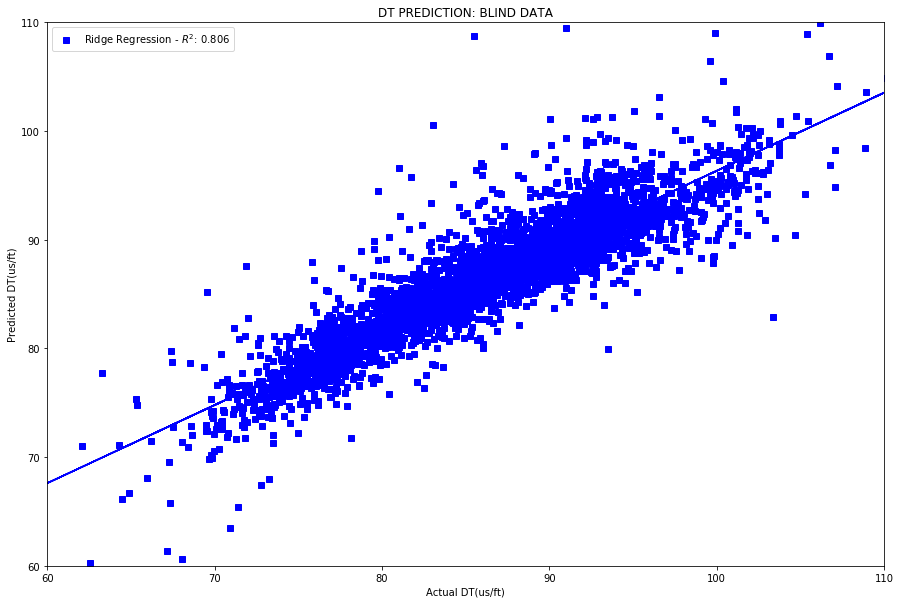

In [59]:
# PLOT FIGURE - ACTUAL VS PREDICTED #
fig = plt.figure(figsize=(15, 10))
plt.plot(y_blind,Y_pred_reg,'bs',
         y_blind,fit1(y_blind),'b-')

plt.xlabel('Actual DT(us/ft)')
plt.ylabel('Predicted DT(us/ft)')
plt.legend(['Ridge Regression - $R^2$: '+str(round(pred_ridge_r2,3))])
plt.xlim(60,110)
plt.ylim(60,110)
plt.title('DT PREDICTION: BLIND DATA')
plt.show()

In [60]:
gardner_dt=1000000/(357*np.power(blind_data.RHOB,4))

Finally, we will calculate DT using the inverse Gardner relationship which is given by the follow equation.

$V_{P}=357\rho^{4}$

Where $V_{P}$ is the compressional velocity in $\frac{ft}{s}$ and $\rho$ is the bulk density in $\frac{g}{cc}$. We can substitute $V_{P}$ for $\frac{10^{6}}{DT}$($\frac{\mu s}{ft}$) and rearrange to solve for DT.

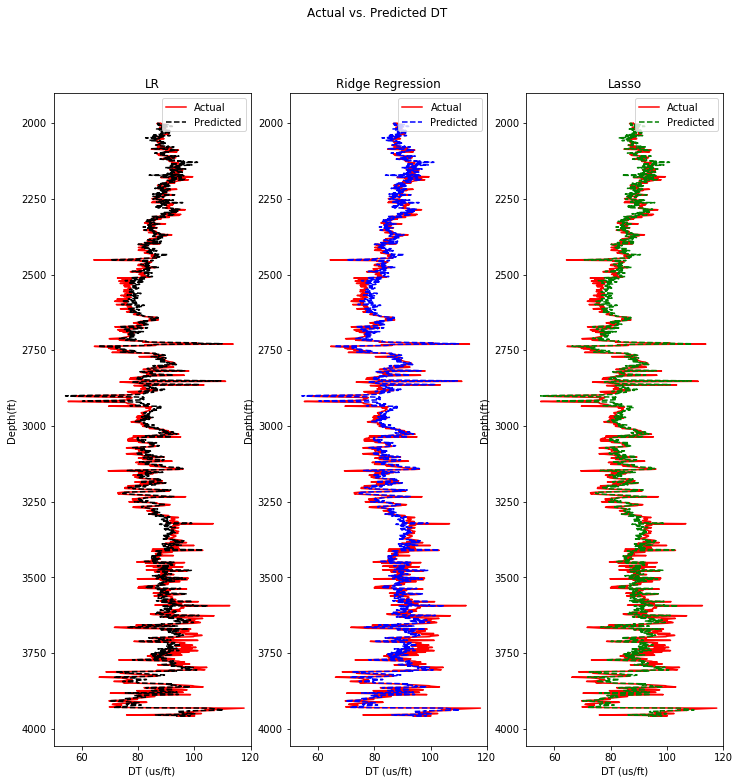

In [61]:
f,ax = plt.subplots(nrows=1,ncols=3, figsize=(12, 12))

ax[0].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[0].plot(Y_pred_reg,blind_data.DEPTH,color='k',linestyle='--',label='Predicted')
ax[0].invert_yaxis()
ax[0].set_xlabel('DT (us/ft)')
ax[0].set_ylabel('Depth(ft)')
ax[0].legend(loc="upper right")
ax[0].set_title('LR')
ax[0].set_xlim([50,120])


ax[1].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[1].plot(Y_pred_ridge,blind_data.DEPTH,color='b',linestyle='--',label='Predicted')
ax[1].invert_yaxis()
ax[1].set_xlabel('DT (us/ft)')
ax[1].set_ylabel('Depth(ft)')
ax[1].legend(loc="upper right")
ax[1].set_title('Ridge Regression')
ax[1].set_xlim([50,120])

ax[2].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[2].plot(Y_pred_lasso,blind_data.DEPTH,color='g',linestyle='--',label='Predicted')
ax[2].invert_yaxis()
ax[2].set_xlabel('DT (us/ft)')
ax[2].set_ylabel('Depth(ft)')
ax[2].legend(loc="upper right")
ax[2].set_title('Lasso')
ax[2].set_xlim([50,120])



plt.suptitle('Actual vs. Predicted DT')
plt.show()

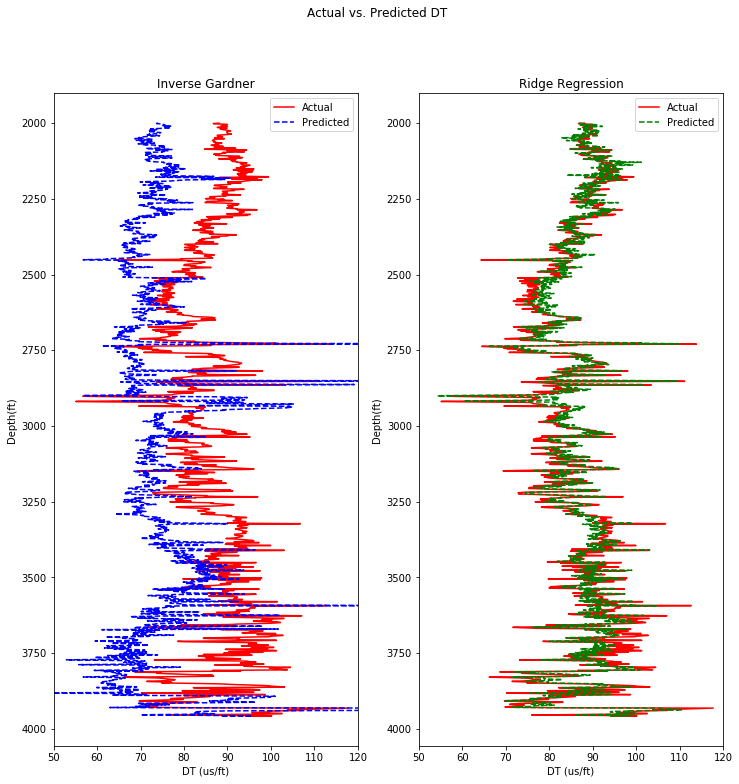

In [62]:
f,ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 12))
ax[0].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[0].plot(gardner_dt,blind_data.DEPTH,color='b',linestyle='--',label='Predicted')
ax[0].invert_yaxis()
ax[0].set_xlabel('DT (us/ft)')
ax[0].set_ylabel('Depth(ft)')
ax[0].legend(loc="upper right")
ax[0].set_title('Inverse Gardner')
ax[0].set_xlim([50,120])

ax[1].plot(y_blind,blind_data.DEPTH,color='r',label='Actual')
ax[1].plot(Y_pred_ridge,blind_data.DEPTH,color='g',linestyle='--',label='Predicted')
ax[1].invert_yaxis()
ax[1].set_xlabel('DT (us/ft)')
ax[1].set_ylabel('Depth(ft)')
ax[1].legend(loc="upper right")
ax[1].set_title('Ridge Regression')
ax[1].set_xlim([50,120])


plt.suptitle('Actual vs. Predicted DT')
plt.show()

## Final Thoughts

In this tutorial, we looked at one possible workflow for DT prediction using triple combo logs. We used three different regressors, namely, Linear, Ridge and Lasso. For the training phase, we tested the model on validation set and saw that all three methods provide very similar results. We then tested different values of regularization parameter, $\alpha$, for Ridge Regression and Lasso. We realized that understanding the parameters for any machine learning algorithm is crucial for successfully applying the method on real dataset. We then tested the robustness of the model on a blind dataset. Finally, we calculated DT using Inverse Gardner and checked the result with observed DT and predicted DT using Ridge Regression. 

As I mentioned before, these are only few simple regressors that I used in this tutorial. You can take this dataset and try other regressors to see if there is a better match to the blind dataset. Also, there are zones within the blind dataset where the prediction is not good. It would be interesting to understand the geologic framework and its effect on prediction. One can also try chopping the data into different lithological zones based on geologic picks before training and predicting. We have just scratched the surface with this tutorial, there are large possibilities in terms of petrophysical evaluation using machine learning.  


### References
Gardner, G. H. F., L. W. Gardner, and A. R. Gregory. "Formation velocity and density—The diagnostic basics for stratigraphic traps." Geophysics 39.6 (1974): 770-780.
